In [ ]:
#importing the required libraries
import time
import cv2
import os, shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import timm

In [ ]:
pip install timm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 5.5 MB/s 
     |████████████████████████████████| 163 kB 41.5 MB/s 


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
os.mkdir('/dataset_1000')
#unzipping and extracting the dataset
!unzip /dataset_1000.zip -d '/dataset_1000'

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# return all files as a list
landmarks_list = []
for file in os.listdir('/Downloads/dataset_1000'):
     # check the files which are end with specific extension
    if file.endswith(".txt"):
        # append path name of selected files
        landmarks_list.append(file)
os.mkdir('/Downloads/dataset_1000/landmarks')
for f in landmarks_list:
  file_path = os.path.join('/Downloads/dataset_1000', f)
  shutil.move(file_path, '/Downloads/dataset_1000/landmarks')
images_list = []
for file in os.listdir('/Downloads/dataset_1000'):
     # check the files which are end with specific extension
    if file.endswith(".png"):
      if file.endswith("seg.png"):
        pass
      else:
        # append path name of selected files
        images_list.append(file)
os.mkdir('/Downloads/dataset_1000/images')
for f in images_list:
  file_path = os.path.join('/Downloads/dataset_1000', f)
  shutil.move(file_path, '/Downloads/dataset_1000/images')
segmented_img_list = []
for file in os.listdir('/Downloads/dataset_1000'):
     # check the files which are end with specific extension
    if file.endswith("seg.png"):
        # append path name of selected files
        segmented_img_list.append(file)
os.mkdir('/Downloads/dataset_1000/segmented_images')
for f in segmented_img_list:
  file_path = os.path.join('/Downloads/dataset_1000', f)
  shutil.move(file_path, '/Downloads/dataset_1000/segmented_images')

70


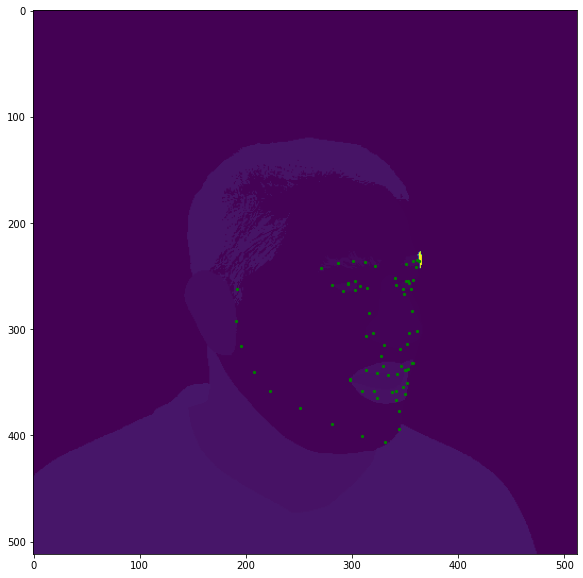

In [ ]:
file = open('/content/gdrive/MyDrive/dataset_1000/landmarks/000000_ldmks.txt')
points = file.readlines()[:]

landmarks = []
i =0 
for point in points:
  i+=1
  x,y = point.split(' ')
  landmarks.append([floor(float(x)), floor(float(y[:-1]))])
print(i)
landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('/content/gdrive/MyDrive/dataset_1000/segmented_images/000000_seg.png'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [ ]:

class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):
      self.image_filenames = []
      self.landmarks = []
      self.crops = []
      self.transform = transform
      path_landmarks = '/content/gdrive/MyDrive/dataset_1000/landmarks'
      path_seg_imgs = '/content/gdrive/MyDrive/dataset_1000/segmented_images'
      landmarks_filenames = sorted(os.listdir(path_landmarks))
      segimg_filenames = sorted(os.listdir(path_seg_imgs))
      for filename in landmarks_filenames:
        file = open(os.path.join(path_landmarks, filename))
        points = file.readlines()[:]
        landmarks = []
        for point in points:
          x,y = point.split(' ')
          landmarks.append([floor(float(x)), floor(float(y))])
        self.landmarks.append(landmarks)
      self.landmarks = np.array(self.landmarks).astype('float32') 
      for filename in segimg_filenames:
        filepath = os.path.join(path_seg_imgs, filename)
        img =   Image.open(filepath)
        crop = {}
        crop['width'] = img.width
        crop['height'] = img.height
        crop['top'] = 0
        crop['left'] = 0
        self.crops.append(crop)
        self.image_filenames.append(os.path.join(path_seg_imgs, filename))
      assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])
        landmarks = landmarks - 0.5
        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())


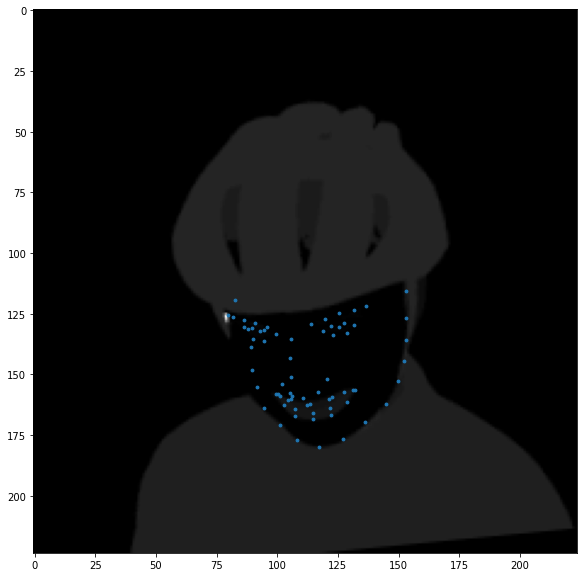

In [ ]:
image, landmarks = dataset[256]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 900
The length of Valid set is 100


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 70, 2])


In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=140):
        super().__init__()
        self.model_name='resnet18'
        self.model = timm.create_model('resnet101', pretrained = True, in_chans = 1)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 200

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet101_a1h-36d3f2aa.pth" to /root/.cache/torch/hub/checkpoints/resnet101_a1h-36d3f2aa.pth


Valid Steps: 13/13  Loss: 0.0169 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0211  Valid Loss: 0.0169
--------------------------------------------------

Minimum Validation Loss of 0.0169 at epoch 1/200
Model Saved

Valid Steps: 13/13  Loss: 0.0128 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0101  Valid Loss: 0.0128
--------------------------------------------------

Minimum Validation Loss of 0.0128 at epoch 2/200
Model Saved

Valid Steps: 13/13  Loss: 0.0092 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0080  Valid Loss: 0.0092
--------------------------------------------------

Minimum Validation Loss of 0.0092 at epoch 3/200
Model Saved

Valid Steps: 13/13  Loss: 0.0082 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0074  Valid Loss: 0.0082
--------------------------------------------------

Minimum Validation Loss of 0.0082 at epoch 4/200
Model Saved

Valid St

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-38n96upt'


Valid Steps: 13/13  Loss: 0.0029 
--------------------------------------------------
Epoch: 25  Train Loss: 0.0025  Valid Loss: 0.0029
--------------------------------------------------
Valid Steps: 13/13  Loss: 0.0026 
--------------------------------------------------
Epoch: 26  Train Loss: 0.0024  Valid Loss: 0.0026
--------------------------------------------------

Minimum Validation Loss of 0.0026 at epoch 26/200
Model Saved

Valid Steps: 13/13  Loss: 0.0023 
--------------------------------------------------
Epoch: 27  Train Loss: 0.0022  Valid Loss: 0.0023
--------------------------------------------------

Minimum Validation Loss of 0.0023 at epoch 27/200
Model Saved

Valid Steps: 13/13  Loss: 0.0029 
--------------------------------------------------
Epoch: 28  Train Loss: 0.0022  Valid Loss: 0.0029
--------------------------------------------------
Valid Steps: 13/13  Loss: 0.0023 
--------------------------------------------------
Epoch: 29  Train Loss: 0.0022  Valid Loss: 

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 512

    predictions = (best_network(images).cpu() + 0.5) * 512
    predictions = predictions.view(-1,70,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

In [ ]:
pip install pyopencl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 932 kB 4.0 MB/s 
     |████████████████████████████████| 70 kB 3.3 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=4daee828aadbe55d679b6412cbd6d2842e0e74a98a11c9ed7c9fb448bd6709f3
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
Successfully built pytools


In [ ]:
import timm 
from PIL import Image

model = timm.create_model('resnet101', pretrained = True, in_chans = 1)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet101_a1h-36d3f2aa.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet101'}

In [ ]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
model.fc


Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
x = torch.randn(1,1,224,224)
model(x)

tensor([[-64.4161, -63.6883, -65.0479, -66.0958, -65.5833, -63.7724, -63.7647,
         -63.6628, -63.5585, -64.6229, -65.4274, -64.7775, -64.8691, -64.3061,
         -64.9955, -64.5582, -64.7826, -64.0101, -64.1025, -64.3574, -65.0566,
         -64.8134, -65.4429, -64.0811, -64.8619, -64.4350, -64.2437, -65.0761,
         -64.2564, -64.9170, -63.4673, -64.9045, -63.7331, -63.6884, -63.9417,
         -63.6144, -63.1337, -63.8029, -64.3132, -62.5463, -64.5138, -64.4733,
         -63.9953, -63.3244, -64.1258, -63.7107, -64.7654, -63.6337, -63.9827,
         -64.1317, -63.9255, -62.6409, -64.4538, -64.3404, -64.1453, -65.0583,
         -64.4052, -64.8787, -64.0751, -65.1803, -64.0521, -63.9734, -64.3587,
         -63.5446, -64.6168, -65.3352, -65.1728, -64.8057, -65.0375, -64.4126,
         -64.5633, -63.8818, -65.2910, -65.0121, -65.2352, -64.0844, -63.9911,
         -64.3636, -64.7906, -63.3014, -65.1168, -65.5327, -64.1934, -64.4719,
         -63.6086, -63.6207, -63.9355, -62.6978, -63